In [2]:
from skimage import feature, color, filters, measure, io
import cv2
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.io import imread

import matplotlib.pyplot as plt
from scipy import ndimage as nd
from skimage.color import label2rgb
import pandas as pd

In [1]:
#Image path
#img=io.imread('/home/mcaroulle/Pheno_Leaf/Data/Optical-distortion/Input/TRAY_1.png')
#plt.imshow(img)

img = io.imread('/home/mcaroulle/Pheno_Leaf/PL_Final/SEGMENTED_INPUT/TRAY10707.png')

##convert to hsv
#hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#mask= cv2.inRange(hsv,(30,20,150),(70,255,255))
mask= cv2.inRange(img,(30,20,150),(70,255,255))

closed_mask = nd.binary_closing(mask, np. ones ((7,7)))

label_image= measure.label(closed_mask)

image_label_overlay = label2rgb(label_image, image= img)
plt.imshow(image_label_overlay)

props = measure.regionprops_table(label_image, 
                                  properties=['label','area','coords'])

df = pd.DataFrame(props)
#print(df.head())

NameError: name 'io' is not defined

### Remove border artefacts

In [3]:
from skimage import segmentation

# remove artifacts connected to image border
cleared_label_image = segmentation.clear_border(label_image)

#take measurements 
props = measure.regionprops_table(cleared_label_image, img,
                                  properties=['label', 'area', 'centroid','coords'])

# Convert props to DataFrame
df = pd.DataFrame(props)

### Filtering by area

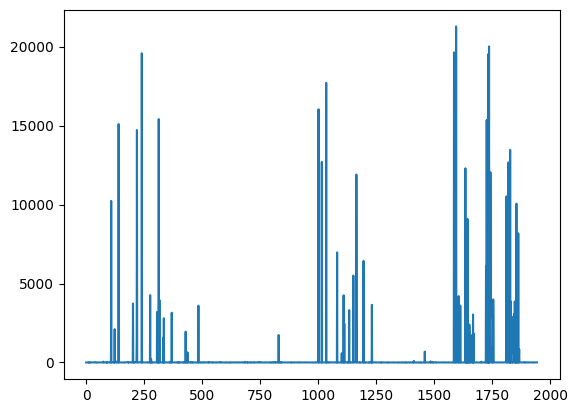

In [4]:
area = df['area']
plt.plot(area)
plt.show()

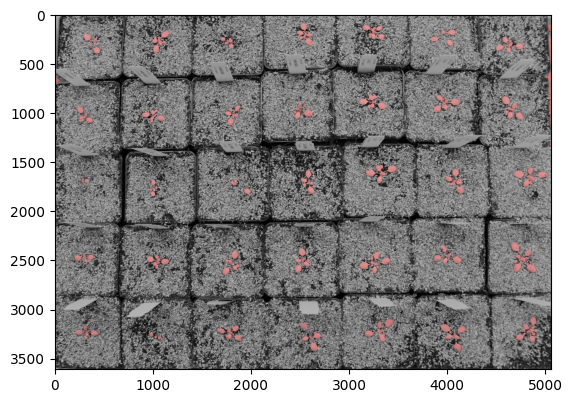

In [5]:
# Filter regions with area less than 5,000
df_filtered = df[df['area'] > 500]

# Filter label_image based on the filtered DataFrame
filtered_label_image = np.isin(cleared_label_image , df_filtered['label'])


image_label_overlay = label2rgb(filtered_label_image, image= img)
plt.imshow(image_label_overlay)

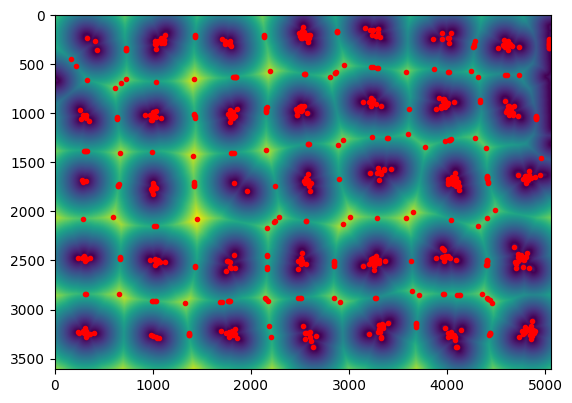

In [6]:
###On définit une fonction qui permet de convertir un masque en une image
def convertir_masque_en_image(mask):
    # Créer une image vide avec les mêmes dimensions que le masque
    image = np.zeros_like(mask)

    # Appliquer le masque à l'image en définissant les pixels blancs
    image[mask > 0] = 255

    # Enregistrer l'image
    return image

image = convertir_masque_en_image(filtered_label_image)

edges = feature.canny(image, sigma=10)

dt = distance_transform_edt(~edges)

local_max = feature.peak_local_max(dt, min_distance=5)

peak_idx = feature.peak_local_max(dt, min_distance=5)

plt.plot(peak_idx[:,1],peak_idx[:,0],'r.')
plt.imshow(dt)

# Creating plants by merging leaves

#### Generate a dataframe with peaks coords

In [7]:
df_peak = pd.DataFrame(peak_idx)
df_peak.columns=['x_coord','y_coord']
df_peak['index_of_label_in_df_coords']=''
df_peak['label']=''

#### Generate a dataframe with label coords

In [8]:
df_filtered_reinit=df_filtered.reset_index(drop=True) #reset of indexes

df_coords=df_filtered_reinit[['label','coords']]

In [9]:

for k in range(len(df_coords)): 
    
    data_coords = df_coords['coords'][k] #array
    coords = data_coords.tolist() #list of list
    x_coords = [sous_liste[0] for sous_liste in coords] #list
    y_coords = [sous_liste[1] for sous_liste in coords] #list 

    # Parcourir les lignes du dataframe
    for index, row in df_peak.iterrows():
        if row['x_coord'] in x_coords and row['y_coord'] in y_coords:
            df_peak.at[index, 'index_of_label_in_df_coords'] = k
        
#Nettoyage du dataframe obtenu
df_peak = df_peak[df_peak['index_of_label_in_df_coords'] != '']

# Recherche des valeurs en double dans la colonne 3
valeurs_en_double = df_peak[df_peak.duplicated(subset='index_of_label_in_df_coords', keep=False)]['index_of_label_in_df_coords'].unique()

# Suppression des lignes en double, sauf la première occurrence
df_peak = df_peak.drop_duplicates(subset='index_of_label_in_df_coords', keep='first')

    

In [10]:
for k in df_peak['index_of_label_in_df_coords']: 
    # Extraction de l'élément de la colonne1 à partir de l'indice
    element = df_coords.loc[k, 'label']

    # Retrouver l'index de la ligne contenant l'élément dans la colonne 3
    index = df_peak.loc[df_peak['index_of_label_in_df_coords'] == k].index[0]

    # Ajouter l'élément dans la ligne donnée de la colonne 3
    df_peak.at[index, 'label'] = element

#### Clean the initial dataframe by removing all objects that are not leaves

In [11]:
df_peak_label=pd.merge(df_filtered_reinit, df_peak, on='label', how='inner')
df_peak_label = df_peak_label.rename(columns={'x_coord' : 'y_coord' , 'y_coord' : 'x_coord'})


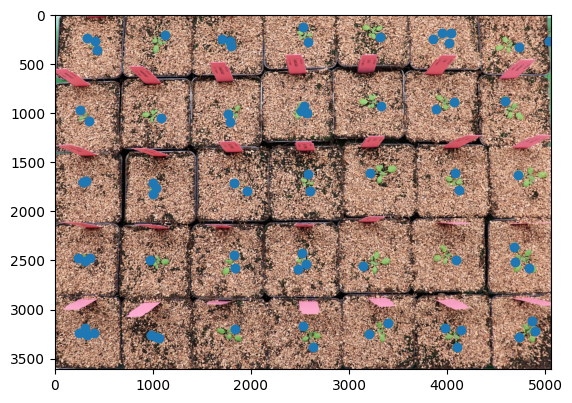

In [12]:
x = df_peak_label['x_coord']
y = df_peak_label['y_coord']
plt.imshow(img)
plt.scatter(x,y)
plt.show()

#### Localisation des pots dans le tray

#### Tray slicing

In [13]:
# Charger l'image
image = imread('/home/mcaroulle/Pheno_Leaf/Data/Optical-distortion/Input/TRAY_1.png')

# Extraire les dimensions de l'image
height, width, channels = image.shape

#Calcul de la largeur et de la hauteur des pots dans le tray
x_pot = width/7
y_pot = height/5


# Création des données qui correspond à un découpage du tray en pots
x_min=[]
x_max=[]
X=[]

for k in range(5):
    x=0
    for k in range (8):
        X.append(int(x))
        x+=x_pot
    x_min+=X[0:7]
    x_max+=X[1:8]
    if x_max[-1]!=width:
        x_max[-1]=width

x_min.sort()
x_max.sort()


y_min=[]
y_max=[]
Y=[]


for k in range(7):
    y=0
    for k in range (6):
        Y.append(int(y))
        y+=y_pot
    Y.sort()
    #print(Y)
    #print(Y[1:6])
    y_max+=Y[1:6]
    y_min+=Y[0:5]
    Y=[]
    if y_max[-1]!=height:
        y_max[-1]=height

#print(len(y_min),len(y_max))

data_tray_max = {'Pot_position': [i for i in range(1, 36)],
        'xmin': [k for k in x_min],
        'xmax': [k for k in x_max],
        'ymin': [k for k in y_min],
        'ymax': [k for k in y_max]}
##Opération sur df_tray_max pour créer df_tray_min

#Calculation of the rejected zone
x_R_pot = int((width/7)/20)
y_R_pot = int((height/5)/20)

df_tray_max = pd.DataFrame(data_tray_max)
df_tray_min = pd.DataFrame(data_tray_max)


df_tray_min['xmin'] = df_tray_min['xmin'] + x_R_pot
df_tray_min['xmax'] = df_tray_min['xmax'] - x_R_pot
df_tray_min['ymin'] = df_tray_min['ymin'] + y_R_pot
df_tray_min['ymax'] = df_tray_min['ymax'] - y_R_pot

#### on assigne chaque a chaque region un pot

In [14]:
#on ajoute une colone vide dans le data_frame df_peak_label qui s appelle pot
df_peak_label['pot'] = ''

#on parcours df_peak_coord et on ajoute le pot correspondant a chaque label


# si le label est en dehors du pot on le vire
# on fusionne les labels qui appartiennent au meme pot
#fini



In [15]:
indices_presents = []

for k in range (len(df_tray_min)):

    # Filtrer les points dans df_peak_label en fonction des coordonnées
    df_subset_peak_label_min= df_peak_label[(df_peak_label['x_coord'] >= df_tray_min['xmin'][k]) & (df_peak_label['x_coord'] <= df_tray_min['xmax'][k]) & (df_peak_label['y_coord'] >= df_tray_min['ymin'][k]) & (df_peak_label['y_coord'] <= df_tray_min['ymax'][k])]

    pot = df_tray_min.loc [k, 'Pot_position']

    index = df_subset_peak_label_min.index.tolist()

    if len(index)>0:
        for k in index : 
            indices_presents.append(k)

    for k in index:
        df_peak_label.loc[k, 'pot'] = pot

# on supprime tous les labels qui ne sont pas associes a un pot
indices_absents= [ k for k in df_peak_label.index.tolist() if k not in indices_presents]
df_peak_label =  df_peak_label.drop(indices_absents)

# Tri du DataFrame en fonction de la colonne 3 par ordre croissant
df_peak_label = df_peak_label.sort_values(by='pot', ascending=True)




### on cree un fonction pour fusionner les labels

In [16]:
import numpy as np

def recuperer_labels_dans_masque(masque, labels):
    labels_dans_masque = []

    for i, val in enumerate(masque):
        if val:
            labels_dans_masque.append(labels[i])

    return labels_dans_masque


In [17]:
masquefusione_list = []  # Liste pour stocker les masquefusione à chaque itération de i

for i in range(1, 36):
    masquefusione = np.zeros_like(label_image, dtype=np.uint8)  # Valeur par défaut, tableau vide
    Labels = df_peak_label.loc[df_peak_label['pot'] == i, 'label'].tolist()

    for k in range(len(Labels)):
        globals()[f'masque_label{k + 1}_{i}'] = np.where(label_image == Labels[k], 255, 0).astype(np.uint8)
        if k == 0 and len(Labels) > 1:
            pass
        elif k == 0 and len(Labels) == 1:
            masquefusione = globals()[f'masque_label{k + 1}_{i}']
        elif k == 1:
            masquefusione = np.logical_or(globals()[f'masque_label{k}_{i}'], globals()[f'masque_label{k + 1}_{i}'])
        else:
            masquefusione = np.logical_or(masquefusione, globals()[f'masque_label{k + 1}_{i}'])

    masquefusione_list.append(masquefusione.copy())  # Stocker une copie de masquefusione à chaque itération


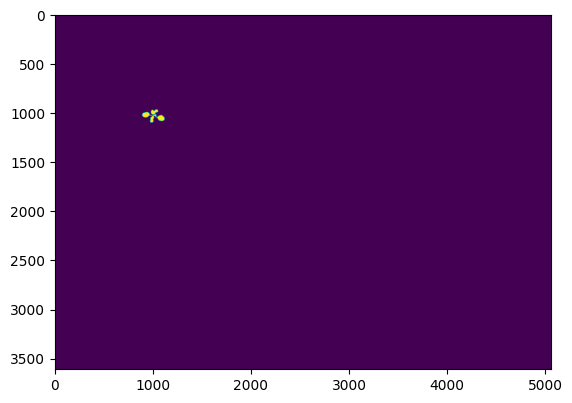

In [18]:
plt.imshow(masquefusione_list[6])

### on recupere ensuite une image pour chaque pot

In [29]:
import cv2
import os
import numpy as np

def split_masks_with_bbox(masks, output_dir):
    """
    1- Function Objective:
    Split the input masks into smaller sub-masks using bounding boxes with a 5% increase in size while keeping the center fixed,
    and save the resulting sub-masks to the specified output directory.

    2- Input Variables and their types:
    - masks (list of np.ndarray): List containing input masks represented as NumPy arrays.
    - output_dir (str): The directory path where the resulting sub-masks will be saved.

    3- Output Variables and their types:
    - None: The function does not return any values. It saves the sub-masks as image files to the specified 'output_dir'.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, mask in enumerate(masks):
        # Convert the mask to np.uint8 data type
        mask = mask.astype(np.uint8)

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) < 1:
            continue

        # Compute the bounding box of all contours
        x, y, w, h = cv2.boundingRect(np.concatenate(contours))

        # Calculate the new dimensions of the bounding box with a 5% increase
        new_w = int(w * 1.1)
        new_h = int(h * 1.1)

        # Calculate the new top-left corner (x, y) to keep the center of the bounding box the same
        new_x = int(x - (new_w - w) / 2)
        new_y = int(y - (new_h - h) / 2)

        # Ensure the new bounding box is within the image bounds
        new_x = max(new_x, 0)
        new_y = max(new_y, 0)
        new_x_end = min(new_x + new_w, mask.shape[1])
        new_y_end = min(new_y + new_h, mask.shape[0])

        # Create a blank mask of the same size as the input mask
        sub_mask = np.zeros_like(mask)

        # Draw all contours on the blank mask
        cv2.drawContours(sub_mask, contours, -1, (255), thickness=cv2.FILLED)

        # Crop the sub-mask using the new bounding box
        sub_mask = sub_mask[new_y:new_y_end, new_x:new_x_end]

        # Save the sub-mask to the output directory
        sub_mask_path = os.path.join(output_dir, f"sub_mask_{i+1}.png")
        cv2.imwrite(sub_mask_path, sub_mask)



masks = masquefusione_list  # Liste des masques à découper
output_directory = "/home/mcaroulle/Pheno_Leaf/Data/pot"  # Dossier de sortie pour les sous-images

split_masks_with_bbox(masks, output_directory)


# analysis


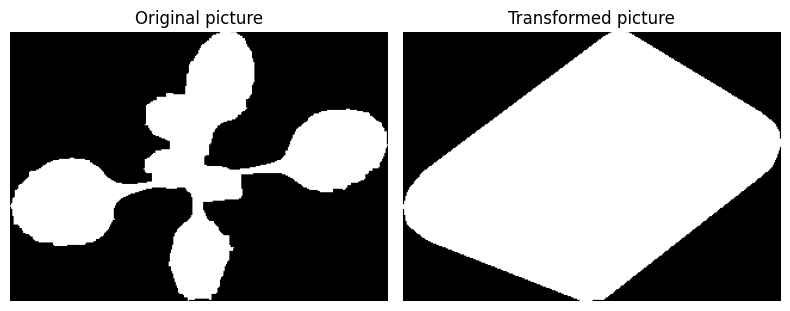

In [20]:
import matplotlib.pyplot as plt

from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert

# The original image is inverted as the object must be white.
image = io.imread('/home/mcaroulle/Pheno_Leaf/Data/pot/sub_mask_24.png')

chull = convex_hull_image(image)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture')
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_axis_off()

ax[1].set_title('Transformed picture')
ax[1].imshow(chull, cmap=plt.cm.gray)
ax[1].set_axis_off()

plt.tight_layout()
plt.show()


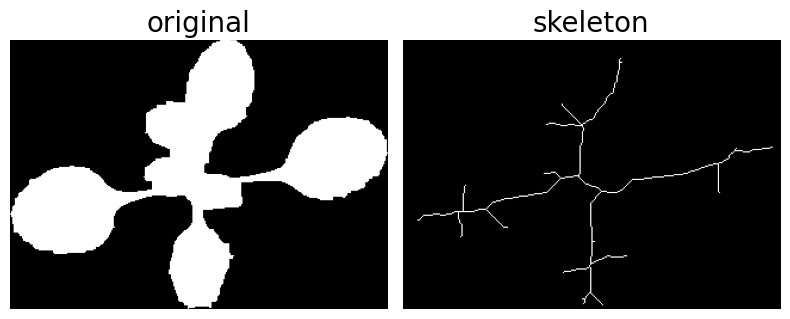

In [21]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
c

# Invert the horse image
image = io.imread('/home/mcaroulle/Pheno_Leaf/Data/pot/sub_mask_24.png')

# perform skeletonization
skeleton = skeletonize(image)
labeled = ndi.label(image)[0]

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()


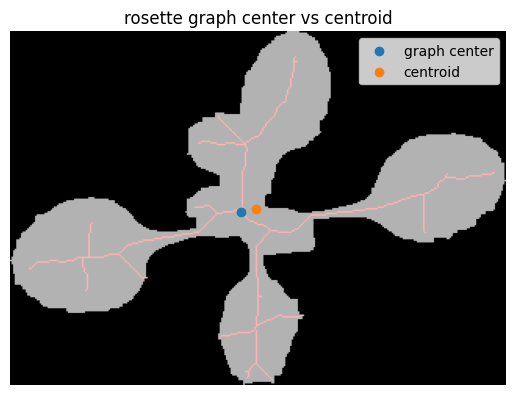

In [22]:
from skimage import color, data, filters, graph, measure

g, nodes = graph.pixel_graph(skeleton, connectivity=2)
px, distances = graph.central_pixel(
        g, nodes=nodes, shape=skeleton.shape, partition_size=100
        )

centroid = measure.centroid(labeled > 0)

_, ax = plt.subplots()
ax.imshow(color.label2rgb(skeleton, image))
ax.scatter(px[1], px[0], label='graph center')
ax.scatter(centroid[1], centroid[0], label='centroid')
ax.legend()
ax.set_axis_off()
ax.set_title('rosette graph center vs centroid')

plt.show()

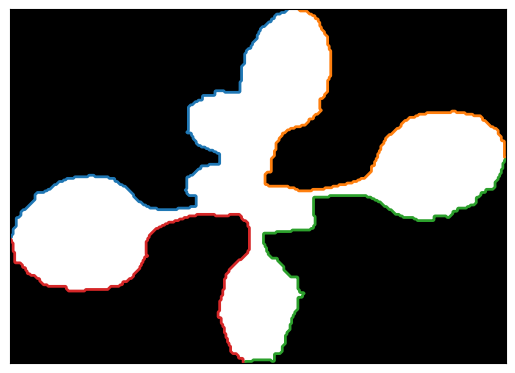

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Convert the inverted image to a 2D array
image_array = np.asarray(image)

# Find contours at a constant value of 0.8
contours = measure.find_contours(image_array)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Plus grande distance: 209.68786326347075
Coordonnées du point le plus distant : [315  84]


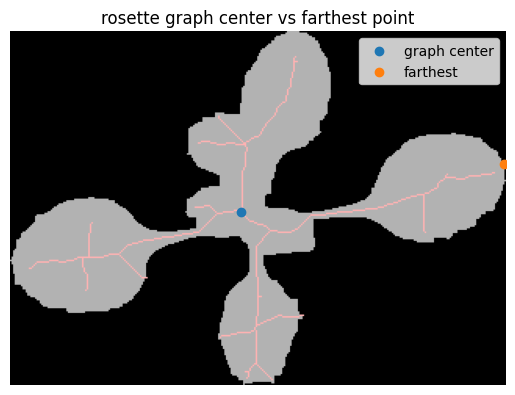

In [24]:
import cv2
import numpy as np
from skimage import feature

# Charger l'image et appliquer la détection de contours
edges = feature.canny(image, sigma=0.6)

# Trouver les contours dans l'image
contours, _ = cv2.findContours(edges.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialiser les variables pour stocker les coordonnées du point le plus distant
max_distance = 0
farthest_point = None

# Parcourir les contours et trouver le point le plus distant
for contour in contours:
    for point in contour:
        distance = np.linalg.norm(np.subtract(px, point[0]))
        if distance > max_distance:
            max_distance = distance
            farthest_point = point[0]

# Afficher la plus grande distance
print("Plus grande distance:", max_distance)

# Afficher les coordonnées du point le plus distant
if farthest_point is not None:
    print("Coordonnées du point le plus distant :", farthest_point)
else:
    print("Aucun point trouvé")


_, ax = plt.subplots()
ax.imshow(color.label2rgb(skeleton, image))
ax.scatter(px[1], px[0], label='graph center')
ax.scatter(farthest_point[0], farthest_point[1], label='farthest')
ax.legend()
ax.set_axis_off()
ax.set_title('rosette graph center vs farthest point')

plt.show()


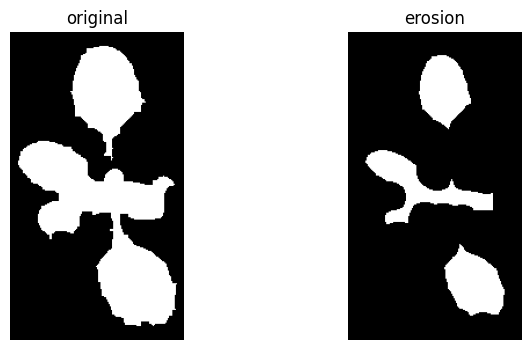

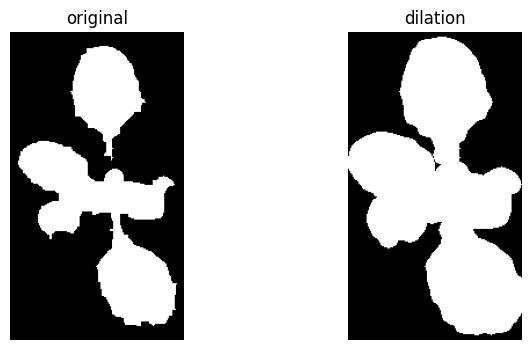

In [22]:
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.morphology import disk, erosion, dilation

orig_phantom = img_as_ubyte(io.imread('/home/mcaroulle/Pheno_Leaf/Data/pot/sub_mask_18.png'))

def plot_comparison(original, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

footprint = disk(8)
eroded = erosion(orig_phantom, footprint)
plot_comparison(orig_phantom, eroded, 'erosion')

dilated = dilation(orig_phantom, footprint)
plot_comparison(orig_phantom, dilated, 'dilation')


/home/mcaroulle/.conda/envs/PhenoLeaf/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


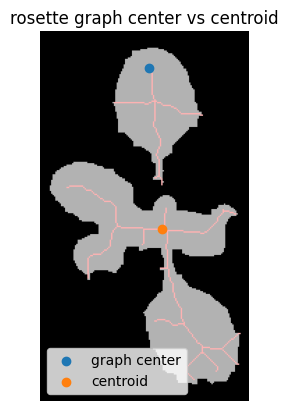

In [21]:
import matplotlib.pyplot as plt
from skimage import io, color, graph, measure
from skimage.morphology import skeletonize

# Invert the horse image
image = io.imread('/home/mcaroulle/Pheno_Leaf/Data/pot/sub_mask_18.png')

# Convert the image to binary
binary_image = image > 0

# perform skeletonization
skeleton = skeletonize(binary_image)

g, nodes = graph.pixel_graph(skeleton, connectivity=2)
px, distances = graph.central_pixel(g, nodes=nodes, shape=skeleton.shape, partition_size=100)

# Find the centroid of the skeletonized image
centroid = measure.centroid(skeleton)

_, ax = plt.subplots()
ax.imshow(color.label2rgb(skeleton, image))
ax.scatter(px[1], px[0], label='graph center')
ax.scatter(centroid[1], centroid[0], label='centroid')
ax.legend()
ax.set_axis_off()
ax.set_title('rosette graph center vs centroid')

plt.show()

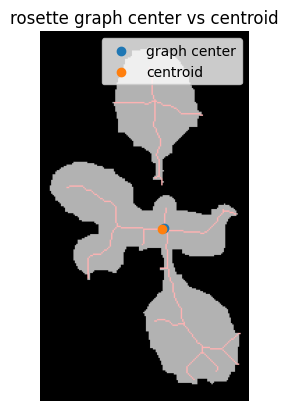

In [24]:
import matplotlib.pyplot as plt
from skimage import graph, measure
from skimage.morphology import skeletonize
import numpy as np
from skimage import feature
from skimage.morphology import disk


def has_multiple_objects(mask):
    # Find contours in the binary mask (working on a copy)
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if there is more than one contour (object)
    return len(contours) > 1

# Function to display the image
# Objective: Display an image using the matplotlib library.
# Input: image (numpy.ndarray) - The image as a NumPy array.
#        title (str) - The title of the image to display.
# Output: None (displays the image in a matplotlib window).

def show_image(image, title):
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

def process_mask(mask_path):
    # Load the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the mask contains multiple objects
    n = 0
    while has_multiple_objects(mask):
        n += 1

        # Perform dilation with a footprint = disk(n) (working on a copy)
        dilated_mask = np.copy(mask)
        footprint = disk(n)
        dilated_mask = cv2.dilate(dilated_mask, footprint)

        # Update the mask for the next iteration
        mask = dilated_mask

    # Return the final mask and the value of n
    return mask, n

def process_mask(mask_path):
    # Load the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the mask contains multiple objects
    n = 0
    while has_multiple_objects(mask):
        n += 1

        # Perform dilation with a footprint = disk(n) (working on a copy)
        dilated_mask = np.copy(mask)
        footprint = disk(n)
        dilated_mask = cv2.dilate(dilated_mask, footprint)

        # Update the mask for the next iteration
        mask = dilated_mask

    # Return the final mask and the value of n
    return mask, n


def Rosette_center_coord(mask, n):
    # Convert the mask to binary
    binary_mask = mask > 0

    # Perform skeletonization
    skeleton = skeletonize(binary_mask)

    if n < 5:
        # Get the graph center coordinates for n < 5
        g, nodes = graph.pixel_graph(skeleton, connectivity=2)
        px, distances = graph.central_pixel(g, nodes=nodes, shape=skeleton.shape, partition_size=100)

        # Return the coordinates of the graph center
        return px[1], px[0]
    else:
        # Get the centroid coordinates for n >= 5
        centroid = measure.centroid(skeleton)

        # Return the coordinates of the centroid
        return centroid[1], centroid[0]

mask,n = process_mask("/home/mcaroulle/Pheno_Leaf/Data/pot/sub_mask_18.png")
x,y = Rosette_center_coord(mask, n)

_, ax = plt.subplots()
ax.imshow(color.label2rgb(skeleton, image))
ax.scatter(x, y, label='graph center')
ax.scatter(centroid[1], centroid[0], label='centroid')
ax.legend()
ax.set_axis_off()
ax.set_title('rosette graph center vs centroid')

plt.show()